In [1]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
from models import *
import torchvision.transforms as transforms
from torch.autograd import Variable
#from models import *
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision import models
from torchvision.models.vgg import VGG

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import scipy.misc
import random
import sys

In [2]:
class FCN16s(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = nn.ReLU(inplace = True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)
        
        return score

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):      
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x
        return output
    
ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [52]:
means = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w  = 480, 640
n_class = 4
model_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/models/fcn"   # 
#model_name = "FCNs_batch12_epoch32_RMSprop_lr0.0001.pkl"
model_name = "FCNs_batch12_epoch40_RMSprop_lr0.0001.pkl"
vgg_model = VGGNet(cfg, requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))

if use_gpu:
    ts = time.time()
    vgg_model = vgg_model.cuda()
    fcn_model = fcn_model.cuda()
    fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)
    print("Finish cuda loading, time elapsed {}".format(time.time() - ts))
state_dict = torch.load(os.path.join(model_dir, model_name))
fcn_model.load_state_dict(state_dict)

mask1 = np.zeros((h, w))
MAXAREA = 18000
MINAREA = 1000

Finish cuda loading, time elapsed 0.01798415184020996


In [53]:
means     = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR
h, w      = 480, 640
val_h     = h
val_w     = w

In [96]:
def predict(img_):
    img = img_[:, :, ::-1]  # switch to BGR
        
    img = np.transpose(img, (2, 0, 1)) / 255.
    img[0] -= means[0]
    img[1] -= means[1]
    img[2] -= means[2]

    # convert to tensor
    img = torch.from_numpy(img.copy()).float()
    img = img.unsqueeze(0)
    #print(img)
    
    output = fcn_model(img.cuda())
    output = output.data.cpu().numpy()

    N, _, h, w = output.shape
    pred = output.transpose(0, 2, 3, 1).reshape(-1, n_class).argmax(axis = 1).reshape(N, h, w)
    #print(pred.shape, N)
    pred_img = np.zeros((pred[0].shape[0], pred[0].shape[1]), np.uint8)
    for i in range(pred[0].shape[0]):
        for j in range(pred[0].shape[1]):
            if pred[0][i][j] == 1: #extinguisher
                pred_img[i][j] = 1
            elif pred[0][i][j] == 2: #drill
                pred_img[i][j] = 3
            elif pred[0][i][j] == 3: #backpack
                pred_img[i][j] = 2
    return pred_img

(480, 640)


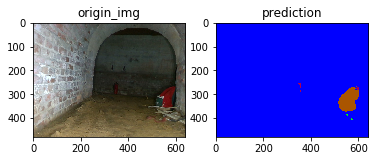

In [153]:
cv_image = cv2.imread("/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/bag3/Images/users/andyser/subt_real/evl_data/bag3/5.jpg", cv2.IMREAD_UNCHANGED)
pred = predict(cv_image)
print(pred.shape)
plt.subplot(1, 2, 1)
plt.title("origin_img")
plt.imshow(cv_image[:, :, ::-1]) #RGB2BGR
#print(img.shape, pred[0].shape)
#print(np.unique(_img[i]))

plt.subplot(1, 2, 2)
plt.title("prediction")
plt.imshow(pred,cmap = "brg",vmin = 0, vmax = n_class - 1)

plt.show()
#generate_img = predict(cv_image)

In [154]:
#im = np.ones((480, 640, 3))*100
im = np.zeros((480, 640, 3))
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        if pred[i][j] == 1:
            im[i][j][0] = 255
        elif pred[i][j] == 2:
            im[i][j][1] = 255
        elif pred[i][j] == 3:
            im[i][j][2] = 255
cv2.imwrite("pred.jpg", im)
cv2.imwrite("orig.jpg", cv_image)

True

extinguisher: 1

drill: 3

backpack: 2

In [100]:
def analysis(pred, target, h, w):
    # TP, FN, FP, TN
    TP = np.zeros(n_class, dtype = np.float128)
    FN = np.zeros(n_class, dtype = np.float128)
    FP = np.zeros(n_class, dtype = np.float128)

    target = target.reshape(h * w)
    pred = pred.reshape(h * w)
    
    con_matrix = confusion_matrix(target, pred,labels = np.arange(0,n_class,1))
    con_matrix[0][0] = 0
    for i in range(0, n_class):
        for j in range(0, n_class):
            if i == j:
                TP[i] += con_matrix[i][j]
            if i != j:
                FP[j] += con_matrix[i][j]
                FN[i] += con_matrix[i][j]
    return TP, FN, FP
                
def pixel_acc(pred, target):
    correct = (pred == target).sum()
    total   = (target == target).sum()
    return correct / total

In [104]:
def val(data_dir, score_dir, name, val_txt):
    #score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/gan_ssd_622"
    if not os.path.exists(score_dir):
        os.makedirs(score_dir)
    TP = np.zeros(n_class-1, dtype = np.float128)
    FN = np.zeros(n_class-1, dtype = np.float128)
    FP = np.zeros(n_class-1, dtype = np.float128)
    total_ious = []
    pixel_accs = []
    data_list = []
    
    csv_data = pd.read_csv(val_txt)
    for idx in range(len(csv_data)):
        img_name = csv_data.iloc[idx, 0]
        label_name = csv_data.iloc[idx, 1]
        input_img = cv2.imread(os.path.join(data_dir, img_name),cv2.IMREAD_UNCHANGED)
        target = cv2.imread(os.path.join(data_dir, label_name), cv2.IMREAD_GRAYSCALE)
        
        pred = predict(input_img)

        h, w = pred.shape

        pixel_accs.append(pixel_acc(pred, target))
        _TP, _FN, _FP =  analysis(pred, target, h, w)
        TP += _TP[1:n_class]
        FN += _FN[1:n_class]
        FP += _FP[1:n_class]
            
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    ious = TP / (TP + FN + FP)
    fscore = 2*TP / (2*TP + FN + FP)
    total_ious = np.array(total_ious).T  # n_class * val_len
    pixel_accs = np.array(pixel_accs).mean()
    
    print("name: {}, pix_acc: {}, meanIoU: {}, IoUs: {}, recall: {}, precision: {}, fscore: {}"\
          .format(name, pixel_accs, np.nanmean(ious), ious, recall, precision, fscore))
    
    f1 = open(score_dir + "/cls_acc_log.txt","a+")
    f1.write('name:'+ str(name) + ', pix_acc: ' + str(pixel_accs) + '\n' )
    f2 = open(score_dir + "/cls_iou_log.txt","a+")
    f2.write('name:'+ str(name) + ', class ious: ' + str(ious) + '\n' )
    f3 = open(score_dir + "/mean_iou_log.txt","a+")
    f3.write('name:'+ str(name) + ', mean IoU: ' + str(np.nanmean(ious)) + '\n' ) 
    f4 = open(score_dir + "/recall_log.txt","a+")
    f4.write('name:'+ str(name) + ', class recall: ' + str(recall) + '\n' )
    f5 = open(score_dir + "/precision_log.txt","a+")
    f5.write('name:'+ str(name) + ', class precision: ' + str(precision) + '\n' )    
    f6 = open(score_dir + "/fscore_log.txt","a+")
    f6.write('name:'+ str(name) + ', class fscore: ' + str(fscore) + '\n' )
    f7 = open(score_dir + "/mean_fscore_log.txt","a+")
    f7.write('name:'+ str(name) + ', mean fscore: ' + str(np.nanmean(fscore)) + '\n' )
    f8 = open(score_dir + "/mean_precision_log.txt","a+")
    f8.write('name:'+ str(name) + ', mean precision: ' + str(np.nanmean(precision)) + '\n' ) 
    f9 = open(score_dir + "/mean_recall_log.txt","a+")
    f9.write('name:'+ str(name) + ', mean recall: ' + str(np.nanmean(recall)) + '\n' ) 

In [105]:
data_dir = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/'
val_txt = '/media/arg_ws3/5E703E3A703E18EB/data/subt_tunnel_hsinchu/test.csv'
score_dir = "/media/arg_ws3/5E703E3A703E18EB/research/subt_fcn/scores/fcn_18mnt"
name = 'fcn_18mnt'

In [106]:
val(data_dir, score_dir, name, val_txt)

name: fcn_18mnt, pix_acc: 0.9949975508432539, meanIoU: 0.49255617435284804, IoUs: [0.44868388 0.61980777 0.40917687], recall: [0.80566988 0.88832447 0.48950138], precision: [0.50313516 0.67218366 0.71375766], fscore: [0.61943656 0.76528559 0.58073174]
